# 畳み込みニューラルネットワーク (CNN)

## 目次
- Section2 汎化性能を上げる
  - 2.1 大規模データセットの利用
  - 2.2 データ拡張
  - 2.3 前処理
  - 2.4 バッチ正規化
  - 2.5 ドロップアウト
  - 2.6 正則化
  - 2.7 初期化

In [1]:
# # Googleドライブのマウント（Colab使いのみ）

# from google.colab import drive
# drive.mount('/content/drive')

# %cd /content/drive/MyDrive/dlc/week3

In [9]:
# 図表が使えるようにする

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

## Section2 汎化性能を上げる

### 2.1 大規模データセットの利用

ディープラーニングの学習に最も大切なものは学習サンプルです。

- ImageNet
- COCO
- Open Image Dataset V6


### 2.2 データ拡張 (Data Augmentation)

CNNは同じサンプルでも大きなズレや回転、反転などがある場合、同じ特徴と認識することができません。そこで、データに様々な変換を加えデータ（特徴量）を増やし解決を試みます。これを **データ拡張** と言います。

データ量が十分でない場合に、水増す目的で用いられることもあります。

In [10]:
# 画像を並べて表示する関数
def tileImgs(imgs, n_cols=3):
    n_rows = int(np.ceil(len(imgs) / n_cols))
    w, h = imgs[0].size

    concat_img = Image.new('RGB', (w * n_cols, h * n_rows))

    for i, img in enumerate(imgs):
        row, col = i % n_cols, i // n_cols
        concat_img.paste(img, (w * row, h * col))

    return concat_img

#### 2.2.1 回転

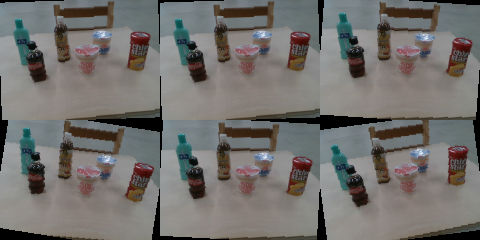

In [16]:
from PIL import Image
from torchvision import transforms

img = Image.open('./figures/example1.png')

transform = transforms.RandomRotation(degrees=10)

imgs = [transform(img) for _ in range(6)]
tileImgs(imgs)

#### 2.2.2 左右反転

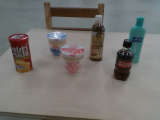

In [17]:
from IPython.display import display
from torchvision import transforms

img = Image.open('./figures/example1.png')

transform = transforms.RandomHorizontalFlip(0.9)
display(transform(img))

#### 2.2.3 左右移動（アフィン変換）

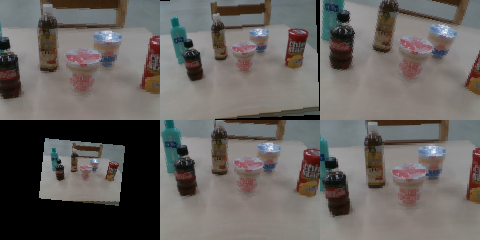

In [21]:
from PIL import Image
from torchvision import transforms

img = Image.open('./figures/example1.png')

transform = transforms.RandomAffine(
    # 回転
    degrees=(-15, 15), 
    # x,y移動
    translate=(0.1, 0.1), 
    # 拡大
    scale=(0.5, 1.5),
    # せん断
    shear=(-1, 1)
)

imgs = [transform(img) for _ in range(6)]
tileImgs(imgs)

#### 2.2.4 射影変換

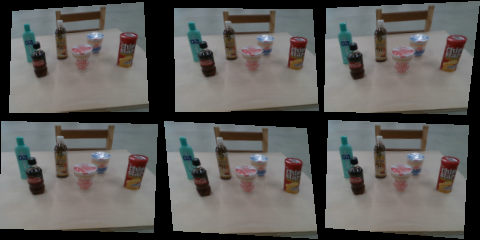

In [7]:
from PIL import Image
from torchvision import transforms

img = Image.open('./figures/example1.png')

transform = transforms.RandomPerspective(distortion_scale=0.2, p=0.9)

imgs = [transform(img) for _ in range(6)]
tileImgs(imgs)

### 2.3 前処理 (Preprocessing)

実際の画像データはノイズなどがあり画像間やピクセル間によって入力の値の分布が異なります。データから意味のある特徴量を際立たせる or 意味のない特徴量 (ノイズ)を除去するために**前処理**が行われます。

#### 2.3.1 正規化

$n$ 個のチャンネルごとの平均 $(m_1, m_2, \cdots, m_n)$ 及び標準偏差 $(s_1, s_2, \cdots, s_n)$ が与えられたとき、チャンネルごとに次の式で標準化を行います。

$$ Output_c = \frac{Input_c - m_c}{s_c} $$

```python
from torchvision import transforms

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        # 各チャンネルの平均
        mean=[0.485, 0.456, 0.406],
        # 各チャンネルの標準偏差 
        std=[0.229, 0.224, 0.225]
    )
])
```

#### 2.3.2 グレースケール

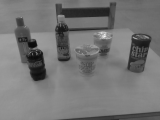

In [22]:
from IPython.display import display
from torchvision import transforms

img = Image.open('./figures/example1.png')

transform = transforms.Grayscale(num_output_channels=1)
display(transform(img))

### 2.4 バッチ正規化 (Batch Normalization)

入力画像に対して正規化をおこなったように、各隠れ層の入力の分布も安定させたいと考えます。 これがない場合、深層のネットワークにおいては層を重ねるほど分布が不安定になります。 特に深層学習において、学習データと検証 (評価)データ間で各層の分布が変わってしまう現象は **内部共変量シフト** と呼ばれます。

**バッチ正規化**では各層の出力を正規化することでこの問題の解決を試みます。

＊バッチ正規化は内部共変量シフトを軽減させる効果が実はほとんどないことが示されています。 一方で損失関数・勾配の形状が緩やかになり、勾配法などによる最適化が容易になることが示されています。

pytorchの場合、ConvやLinearのように層として追加します。

```python
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Conv2d(feature_map*8, feature_map*4, 4, 2, 1, bias=True)
        self.bn1 = nn.BatchNorm2d(feature_map*4) #バッチ正規化
```

### 2.5 ドロップアウト (Dropout)

過学習の要因である統計的なばらつきを相殺するため、各モデルの予測結果を平均する**アンサンブル法**というものがあります。

**ドロップアウト**は入力の一部をランダムに0にして出力するlayerの一種です。要するに一部のユニットを取り除いた状況を再現します。確率的にユニット除去を行うことで、多数のモデルを同時に訓練すること（アンサンブル法）と同じ効果を再現しているわけです。

pytorchの場合、ConvやLinearのように層として追加します。

```python
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Conv2d(feature_map*8, feature_map*4, 4, 2, 1, bias=True)
        self.dr1 = torch.nn.Dropout2d(p=0.3)
```

### 2.6 正則化 (Regularization)

過学習が発生する理由の一つは、モデルが多くのパラメータ・自由度を持つために、訓練データに対して統計的ばらつきまで含めて完全にフィットしようとしてしまうことにあります。

そこで、損失関数にパラメータの大きさに対するペナルティ項（正則化項）を含めます。これにより, パラメータを自由に動けないように制限し、なるべく少ないパラメータでデータにフィットするようにできます。

正則化には様々な種類が存在し、主にL2,L1正則化またそれらを組み合わせたElasticNetが用いられます。

### 2.7 初期化 (Initializer)

学習時、ネットワークのパラメータは乱数で初期化します。しかし、大きすぎる値で初期化すれば学習の初期段階での勾配が過大になり、逆に小さすぎる値だと勾配自体も過小になってしまい、いずれにしても学習はうまく進みません。ネットワークの層が深いほどその確率は上がります。そのため、ばらつきが小さくするなるような初期化を行う必要があります。

#### 2.7.1 Xavierの初期化

各層の入力次元を $n_{in}$、出力次元を $n_{out}$ として次のように初期化します。

$$ \theta \sim \mathcal{U}\left(-\sqrt{\frac{6}{n_{\textrm{in}}+n_{\textrm{out}}}}, \sqrt{\frac{6}{n_{\textrm{in}}+n_{\textrm{out}}}}\right) \quad \textrm{or} \quad \mathcal{N}\left(0, \sqrt{\frac{2}{n_{\textrm{in}}+n_{\textrm{out}}}}\right) $$ 

なお、$\mathcal{U}$ は一様分布、$\mathcal{N}$ は正規分布を表します。


pytorchの場合、層のweightにアクセスすることで初期値を変えることができます。

```python
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Conv2d(feature_map*8, feature_map*4, 4, 2, 1, bias=True)
        # Xavierの初期化
        nn.init.xavier_normal_(fc1.weight, gain=1.0)
```

#### 2.7.2 Heの初期化

各層の入力次元を $n_{in}$ として次のように初期化します。

$$ \theta \sim \mathcal{U}\left(-\sqrt{\frac{6}{n_{\textrm{in}}}}, \sqrt{\frac{6}{n_{\textrm{in}}}}\right) \quad \textrm{or} \quad \mathcal{N}\left(0, \sqrt{\frac{2}{n_{\textrm{in}}}}\right) $$ 

なお、$\mathcal{U}$ は一様分布、$\mathcal{N}$ は正規分布を表します。


pytorchの場合、層のweightにアクセスすることで初期値を変えることができます。

```python
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Conv2d(feature_map*8, feature_map*4, 4, 2, 1, bias=True)
        # Heの初期化
        nn.init.kaiming_normal_(fc1.weight)
```